In [1]:
# Loading all the necessary modules
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import LogNorm

# REMEMBER THE SURROGATE MODEL FILE WHERE THE RBF CLASS IS IMPLEMENTED
import surrogate as sg
from importlib import reload
reload(sg);


# 2D Diamond Airfoil Test Function


## Using the HiSA density based OpenFOAM solver:

<table><tr>
    <td> 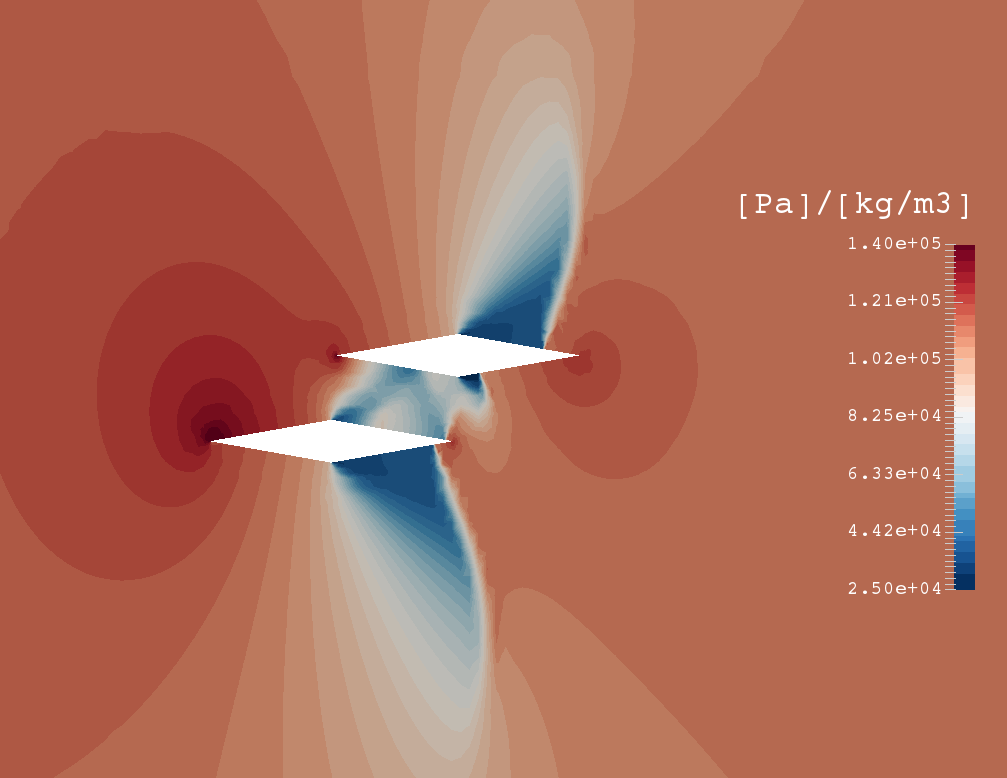 </td>
    <td> 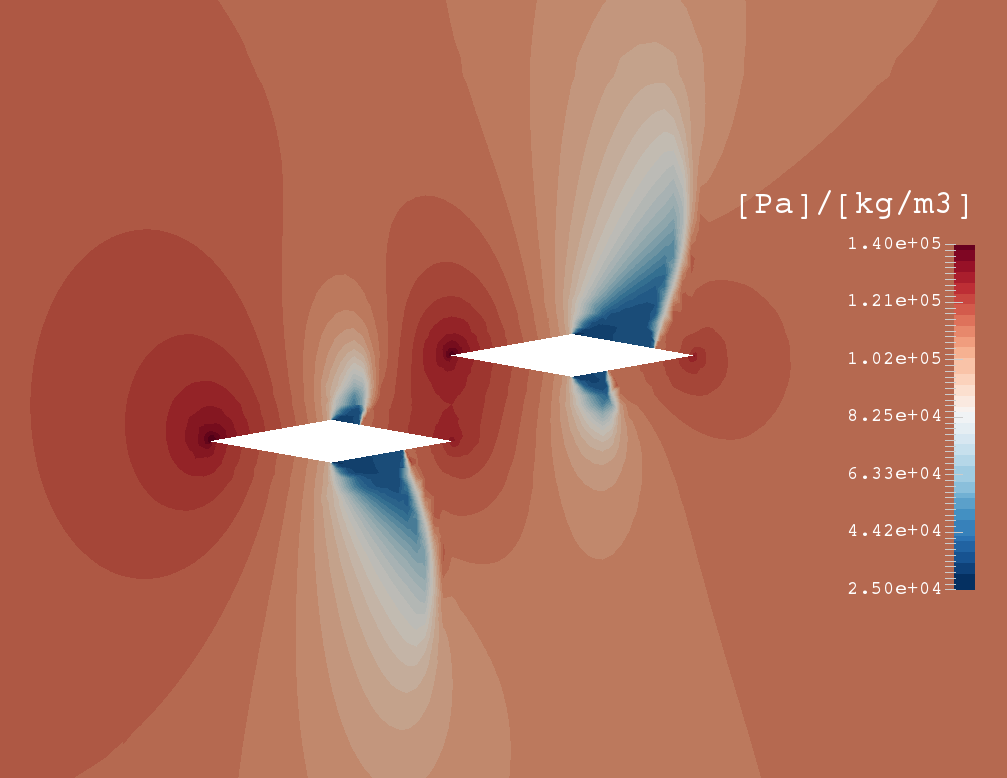 </td>
</tr></table>
(a) 0.52 m @ 258.2 m/s and (b) 0.99 m @ 258.2 m/s


<table><tr>
    <td> 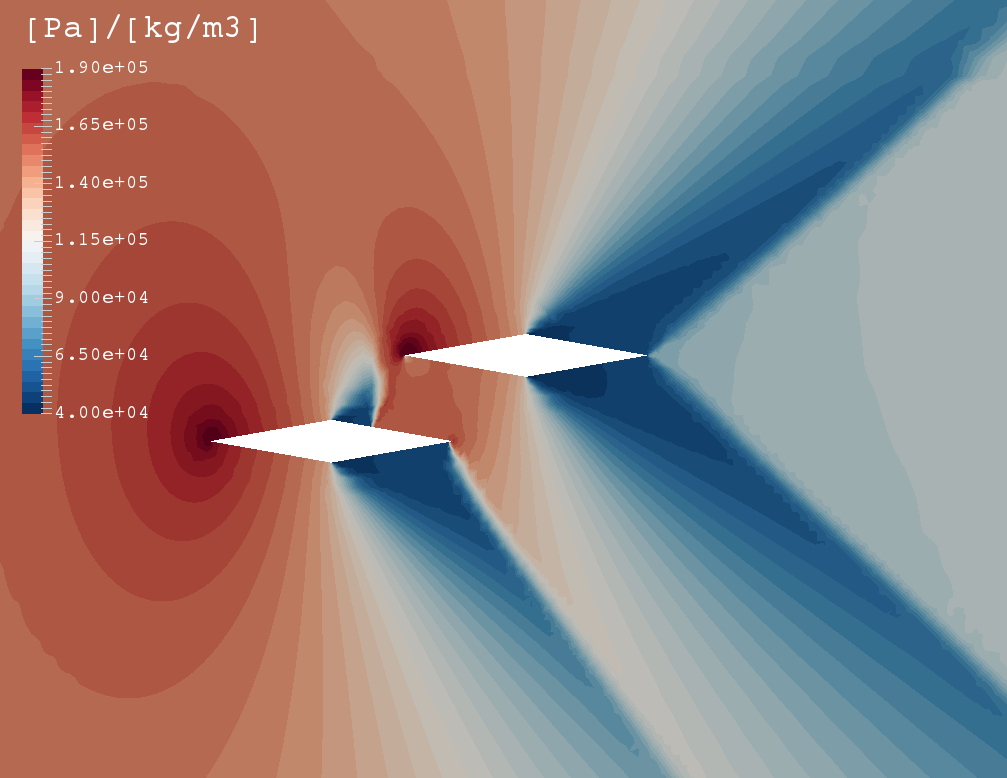 </td>
    <td> 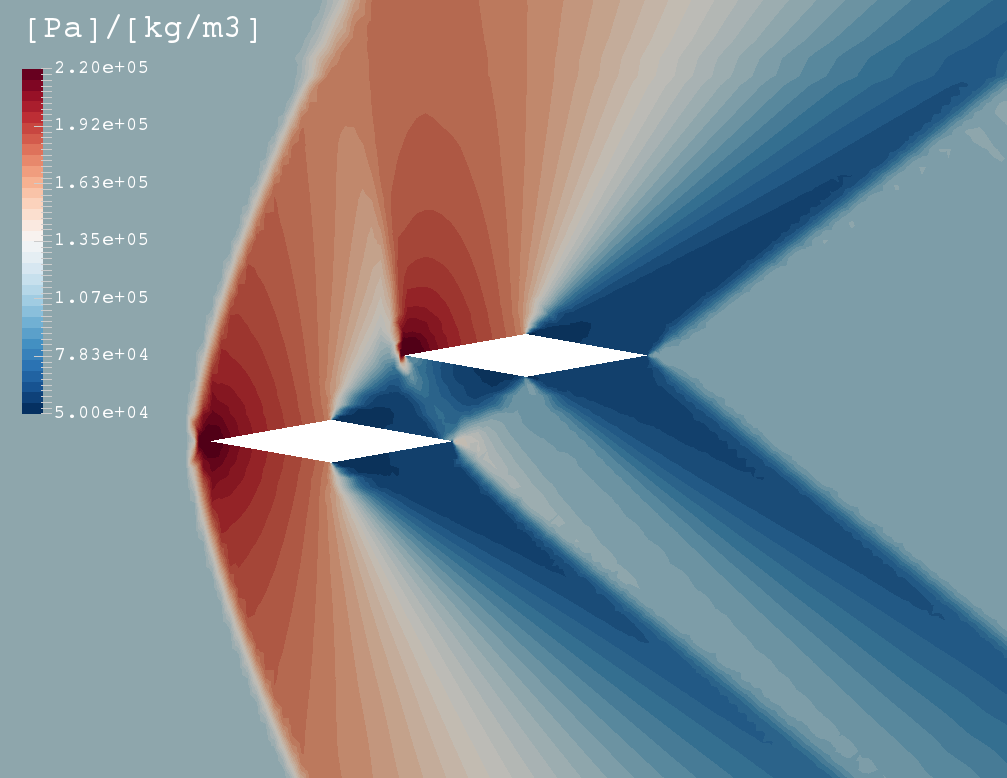 </td>
</tr></table>
(c) 0.88 m @ 361.6 m/s and (d) 0.99 m @ 427.4 m/s



<table><tr>
    <td> 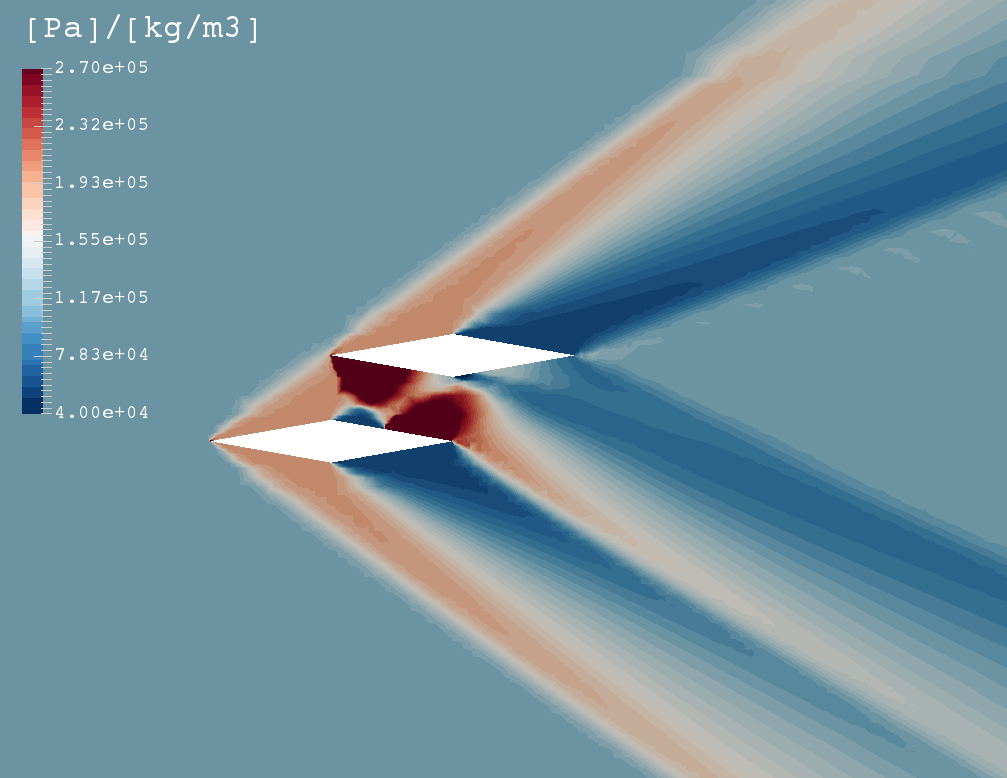 </td>
    <td> 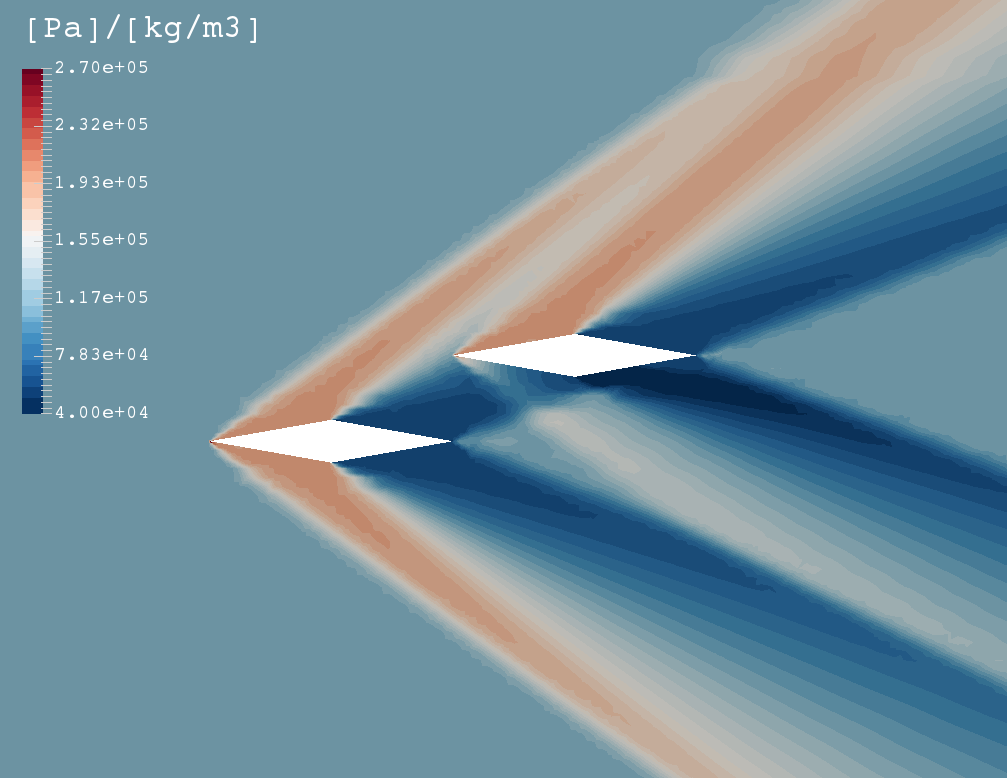 </td>
</tr></table>

(e) 0.5 m @ 700 m/s and (f) 1.0 m @ 700 m/s 



## Extracted Lift, Drag and Moment Coefficients:



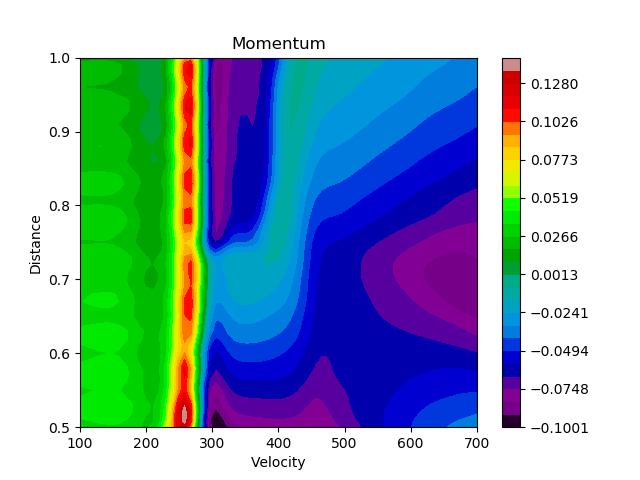


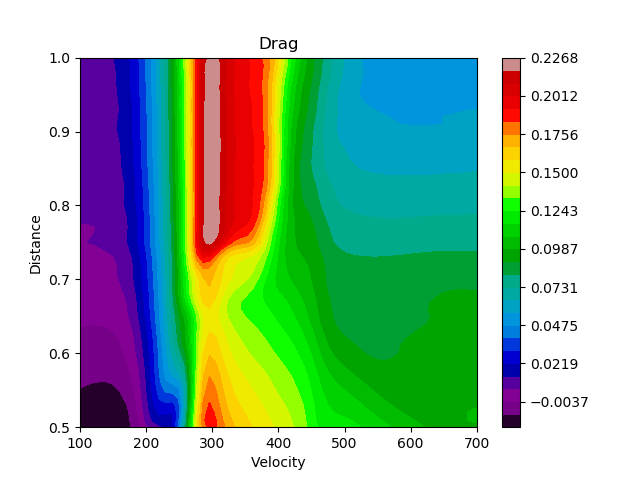


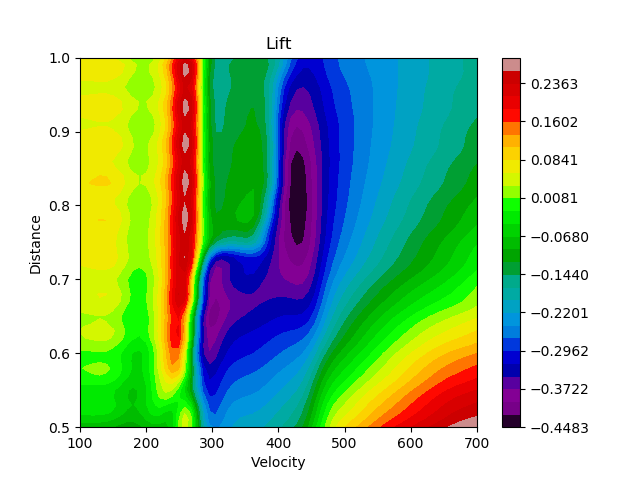
    
   

In [2]:
# Lif coefficients are in a *.csv file:
CLdata = open('Lift_coefficient.csv','r').read()

print(CLdata)

Velocity, Distance, Lift
226.31579200, 0.86842105, 0.10970189
352.63157800, 0.65789473, -0.35271566
573.68420800, 0.50000000, 0.18034628
447.36842200, 0.97368421, -0.32904739
700.00000000, 0.78947368, -0.07813563
636.84210400, 0.92105263, -0.18148451
100.00000000, 0.89473684, 0.06405676
605.26315600, 0.68421053, -0.06698574
510.52631800, 0.60526316, -0.07108189
194.73684400, 1.00000000, 0.03385756
163.15789600, 0.63157895, 0.00503439
384.21052600, 0.81578947, -0.19813060
542.10526600, 0.84210527, -0.23682504
415.78947400, 0.52631579, -0.18549452
131.57894800, 0.76315789, 0.07478438
257.89473400, 0.55263158, -0.04806623
321.05263000, 0.94736842, -0.15016475
289.47368200, 0.73684211, -0.08184528
478.94737000, 0.71052631, -0.27740481
668.42105200, 0.57894737, 0.14895566
342.10526200, 0.57894737, -0.29059485
178.94736700, 0.52631579, -0.06847859
231.57894700, 0.51754386, -0.02439939
139.47368350, 0.51315789, -0.06173833
173.68421200, 0.92105263, 0.03514634
147.36842200, 1.00000000, 0.05788

In [3]:
#
# points where the surrogate model is evaluated 
Vs = np.linspace(100,700,51)
Ds = np.linspace(0.5,1,51)
# mesh grid og points
Vx,Dx = np.meshgrid(Vs,Ds)
# full resolution (all x's)
x = np.c_[Vx.flatten(),Dx.flatten()]
#
#
# read data from the text file into usefull arrays:
CL_data = np.genfromtxt('Lift_coefficient.csv',delimiter=',')[1:]
x_i = CL_data[:,:2]
f_i = CL_data[:,-1]

print(" >> NUMBER OF POINTS : %i"%f_i.size)



# define the funtion to print the coeffient
def plotfig(fx,points=None, cmap=cm.nipy_spectral,levels=None):
    
    if levels is None:
        levels=np.linspace(np.min(fx),np.max(fx),50)
        
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    cf1 = ax1.contourf(Vs,Ds,fx.reshape(51,-1),cmap=cmap,levels=levels)
    if not points is None:
        ax1.plot(points[:,0],points[:,1], 'o', 
                 markersize=5, 
                 markerfacecolor='w',
                 markeredgewidth=1., markeredgecolor='k')
    cb1 = plt.colorbar(cf1,ax=ax1)
    ax1.set_xlabel('True Velocity',fontsize=14)
    ax1.set_ylabel('Distance',fontsize=14)
    
    return fig



 >> NUMBER OF POINTS : 200



 >> Kernel Length Scale = 2.0000 


 >> Full cross-validation error = 0.8009 



<IPython.core.display.Javascript object>


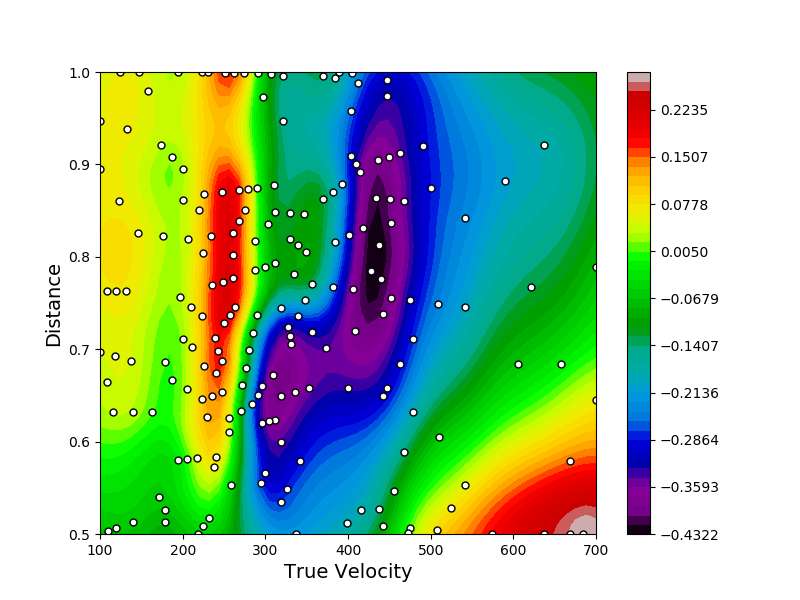

In [4]:
std_CL = True
#
fit_length_scale = not True

fit_using = ['cross-validate','likelihood'][1]

function = ['gaussian','thin_plate','compact_support'][2]

epsilon = [0.1,0.5,1.,2,100.][3]

# construct surrogate:
CL_rbf = sg.rbf(x_i,f_i,
                function=function,
                epsilon=epsilon,
                standardise=std_CL)


print("\n >> Kernel Length Scale = %.4f \n"%CL_rbf.epsilon)
print("\n >> Full cross-validation error = %.4f \n"%CL_rbf.cross_validate(bins=None))

if fit_length_scale:
    from time import time
    if fit_using == 'cross-validate':
        t0 = time()
        print("\n >> Initial cross-validation error = %.4f \n"%CL_rbf.cross_validate(bins=10))
        CL_rbf.fit(using='cross-validate',bins=10)
        print("\n >> Kernel Length Scale = %.4f \n"%CL_rbf.epsilon)
        print("\n >> Final cross-validation error = %.4f  in %.4f seconds\n"%(
            CL_rbf.cross_validate(bins=10),time()-t0))
    else:
        t0 = time()
        print("\n >> Initial log(MLE) = %.4f \n"%CL_rbf.log_likelihood())
        CL_rbf.fit()
        print("\n >> Kernel Length Scale = %.4f \n"%CL_rbf.epsilon)
        print("\n >> Final log(MLE) = %.4f  in %.4f seconds\n"%(CL_rbf.log_likelihood(),time()-t0))
    
    print("\n >> Full cross-validation error = %.4f \n"%CL_rbf.cross_validate(bins=None))

CL_fx = CL_rbf(x)

fig = plotfig(CL_fx,points=x_i)


In [5]:
CL_rbf.log_likelihood()

101.44390948140855

<IPython.core.display.Javascript object>


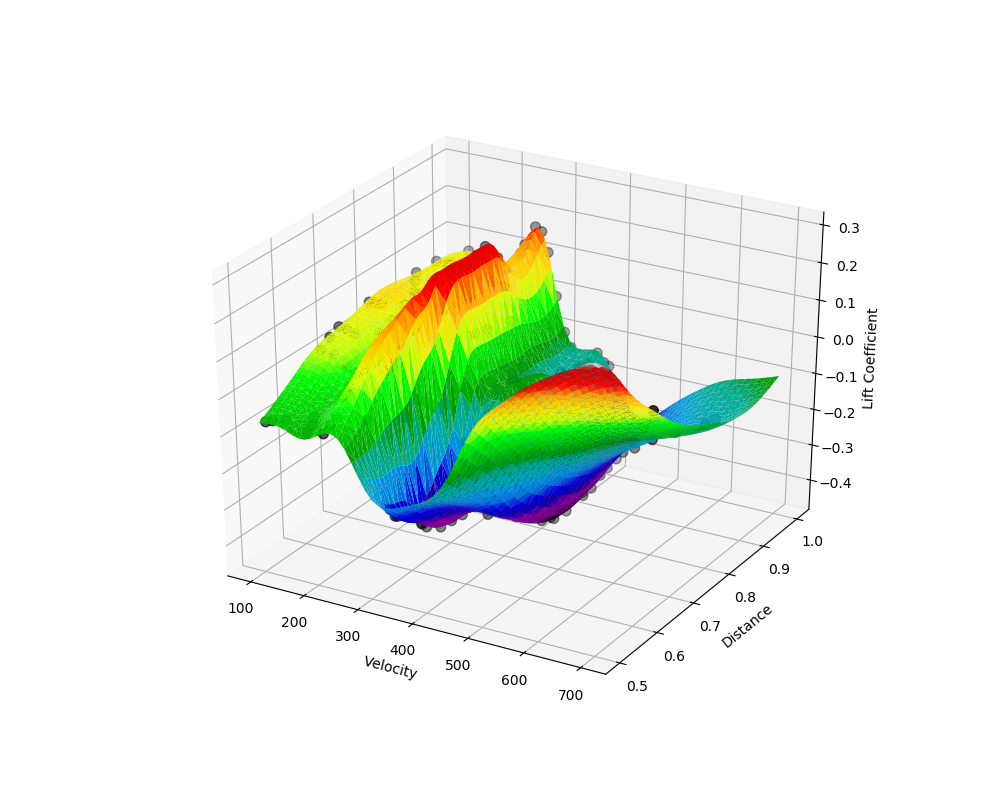

Text(0.5,0,'Lift Coefficient')

In [6]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d');
ax.plot_trisurf(Vx.flatten(),Dx.flatten(), CL_fx.flatten(), cmap=cm.nipy_spectral)#,linewidth=0.2, antialiased=True);
ax.scatter3D(CL_data[:,0],CL_data[:,1],CL_data[:,2],c='k',s=50)
ax.set_xlabel('Velocity')
ax.set_ylabel('Distance')
ax.set_zlabel('Lift Coefficient')

In [7]:
#
#
# CONSTRUCT A SAMPLING FUNCTION:
#
# The RBF object gives access to analytical grandients as well as error / uncertainty estimates:

CL_fx, CL_gradient, CL_uncertainty = CL_rbf(x,gradient=True,error=True)

#print(x)




 >> Plotting [ || d[CL]/d[X] || ] between 0.0027 and 1.7210




<IPython.core.display.Javascript object>


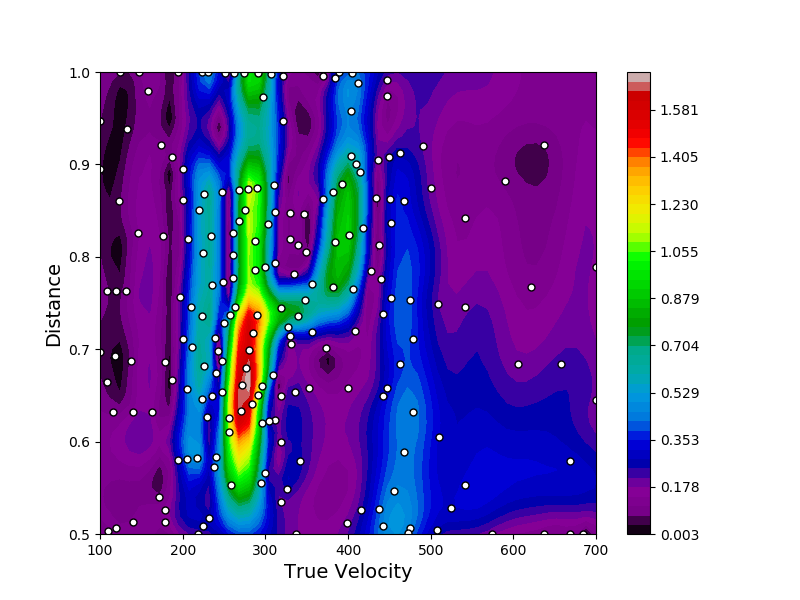

In [8]:
plot_name = ['d[CL]/d[Velocity]','d[CL]/d[Distance]','|| d[CL]/d[X] ||','Uncertainty'][2]

plot_f = {'d[CL]/d[Velocity]':CL_gradient[:,0],
          'd[CL]/d[Distance]':CL_gradient[:,1],
           '|| d[CL]/d[X] ||':np.sqrt(np.sum(CL_gradient*CL_gradient,1)),
                'Uncertainty':CL_uncertainty}[plot_name]

minf,maxf = min(plot_f),max(plot_f)

if minf<maxf:
    print("\n\n >> Plotting [ %s ] between %.4f and %.4f\n\n"%(plot_name,minf,maxf))
    levels = np.linspace(minf,maxf,50)
    fig = plotfig(plot_f,points=x_i,levels=levels)
else:
    print("\n\n >> UNABLE to plot [ %s ] between %.4f and %.4f\n\n"%(plot_name,minf,maxf))
    




<IPython.core.display.Javascript object>


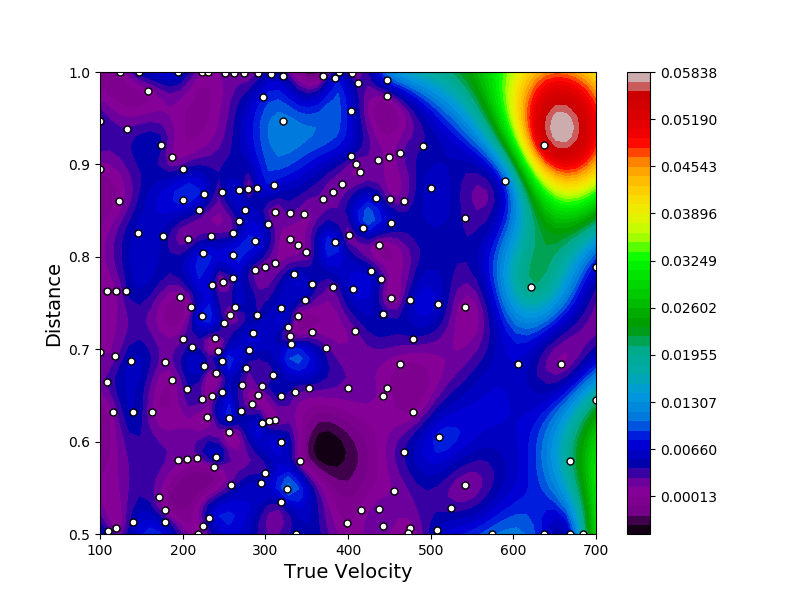

In [9]:
#
#
# >> if cross-validation error has been performed, these is a "per-sample" cross validation error value [f_xve]:

calc_cross_validation = True

if calc_cross_validation:    
    CL_rbf.cross_validate(bins=None,
                          randomise=True)


# Try to construct and plot a cross-validation error field approximate if it's available:
try:
    XVE_rbf = sg.rbf(x_i,
                     CL_rbf.f_xve,
                     **CL_rbf.kwdict # Using the same settings specified / tuned to the Lift Coefficient RBF
                    )

    f_i_xve = XVE_rbf(x)

    fig = plotfig(f_i_xve,points=x_i)
    
except:
    print(" Cross validtaion error needs to be calculated first")

